<img src="https://drive.google.com/uc?id=181S0KcAdGeAajZ1apcbOvoh3wvYuKtzd">
<b>Autores</b>:

*   Aldo von Wangenheim (aldo.vw@ufsc.br)
*   Rodrigo de Paula e Silva Ribeiro (ribeiro.rodrigo@posgrad.ufsc.br)


CERTIFIQUE-SE DE TER INCIADO O AMBIENTE EM MODO <b>GPU</b> ANTES DE REALIZAR OS PROCEDIMENTOS.<br>
NA TROCA DO AMBIENTE ELE <b><u>PERDE</u></b> TODOS OS DADOS BAIXADOS.

AO RE-EXECUTAR OS PROCEDIMENTOS (ex. diminuir o batch size), <br>REINICIE O AMBIENTE PARA LIBERAR O CACHE DO PYTORCH (reiniciar não perde os dados da sessão).<br>(alt+m ou pelo menu "Ambiente de Execução")

EXECUTE UTILIZANDO RUN ALL ou CTRL+F9


#ESTE BLOCO ABAIXO FUNCIONA COMO UM LOG DE TODAS AS CELULAS.

In [ ]:
#@title Célula de log
%%javascript
const listenerChannel = new BroadcastChannel('logger');
listenerChannel.onmessage = (msg) => {
  const div = document.createElement('div');
  div.textContent = msg.data;
  document.body.appendChild(div);
};

<IPython.core.display.Javascript object>

In [ ]:
!nvidia-smi
!nvcc --version

Tue Nov 22 04:13:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Configurações dos Loggers Externos

## Descrição dos Loggers e suas funções.
Este notebook oferece logging de informações do treino para ambiente externo.
Mais especificamente para: [WandB](https://wandb.ai/) e [Neptune](https://neptune.ai/).<br>
WandB e Neptune são gerenciadores de projetos de machine learning que possibilitam a comparação analítica de maneira facilitada entre vários treinos de um mesmo modelo comparando diferentes parâmetros.<br>
Há ainda opções avançadas para salvar modelos e datasets na nuvem (necessita assinatura paga) de forma a facilitar a portabilidade entre diferentes frameworks de ML.<br>
Para utilizá-los, é necessário acessar o site (clikar nos links acima) e efetuar um cadastro gratuito para obter uma chave de api.<br>
Após, alterar no bloco abaixo, os locais indicados com as chaves e mudar a variável de ativação para "True".<br>
Caso não deseje utilizar loggers externos, manter as variáveis de ativação em "False".<br>
O [Detectron2](https://github.com/facebookresearch/detectron2), por padrão, ao final do treino, irá gerar um arquivo 'metrics.json', onde é possível visualizar e analisar os dados de treino e eventualmente montar seu próprio comparador analítico entre treinos.

In [ ]:
PLOT_LOSS = True # Ativa gráfico de loss em tempo real no notebook no bloco (Training Loss)

"""
# EXTERNAL LOGGERS
"""
WANDB_LOGGER = False # Ativa o log das métricas básicas no wandb.ai, requer mais configurações abaixo.
NPT_LOGGER = False # Ativa o log das métricas básicas no nepture.ai, requer mais configurações abaixo.

"""
# WANDB CONFIG
"""
WANDB_API_KEY = "***" # wandb.ai api-key, trocar *** por sua api key
WANDB_PROJECT_NAME = "Cones-Teste" # Nome do projeto onde será logado as métricas (pode ser projeto já existente), caso deixe vazio será gerado um nome aleatório no wandb.ai
WANDB_ENTITY = "wndb_username" # A entidade que está enviando os dados.
WANDB_RUN_ID = "" # Em caso de resumo é necessário passar o RUN-ID para continuar logando as métricas na mesma run.

"""
# NEPTUNE CONFIG
"""
NPT_PROJECT_NAME = "---" # O nome do projeto para o qual será enviado os dados (definido no neptune.ai).
NPT_TOKEN = "***" # A api token do neptune.ai, trocar *** pela sua api key fornecida no neptune.ai
NPT_RUN_ID = "" # Em caso de resumo é necessário passar o RUN-ID para continuar logando na mesma run.


In [ ]:
!pip install wandb -q
!pip install neptune-client -q

     |████████████████████████████████| 1.9 MB 3.9 MB/s 
     |████████████████████████████████| 182 kB 24.3 MB/s 
     |████████████████████████████████| 168 kB 12.4 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████████████████| 166 kB 10.4 MB/s 
     |████████████████████████████████| 166 kB 50.0 MB/s 
     |████████████████████████████████| 162 kB 14.0 MB/s 
     |████████████████████████████████| 162 kB 9.8 MB/s 
     |████████████████████████████████| 158 kB 6.5 MB/s 
     |████████████████████████████████| 157 kB 22.0 MB/s 
     |████████████████████████████████| 157 kB 22.9 MB/s 
     |████████████████████████████████| 157 kB 27.4 MB/s 
     |████████████████████████████████| 157 kB 22.5 MB/s 
     |████████████████████████████████| 157 kB 25.3 MB/s 
     |████████████████████████████████| 157 kB 24.5 MB/s 
     |████████████████████████████████| 157 kB 21.4 MB/s 
     |████████████████████████████████| 156 kB 24.6 MB/s 
     |█████████████

#Training Loss (tempo real)
Visualização da curva de loss em tempo real durante o treino.<br>
Este é um "workaround" específico para o colab para gerar um gráfico de loss em tempo real durante o treino. Ele é ativado pela variável "PLOT_LOSS" do bloco acima.

In [ ]:
#@title Gráfico Loss
import IPython
import numpy as np
from IPython.display import display, HTML, Javascript
import time
import random

def configure_browser_state():

  #display(Javascript('''google.colab.output.setIframeHeight("500")'''))
  display(IPython.core.display.HTML(''' <script src="https://cdn.jsdelivr.net/npm/chart.js@3.9.1"></script>
        <script>
          const _div1 = document.createElement('div');
          _div1.id = "mdiv1";
          _div1.style.width = "50%";
          document.body.appendChild(_div1);
          const _canvas = document.createElement('canvas');
          _canvas.id = "lossChart";
          //_canvas.setAttribute("height", "80"); // usar em caso de width > 50% para limitar altura
          document.getElementById('mdiv1').appendChild(_canvas);
          var ctx = document.getElementById('lossChart').getContext('2d');
          var chart = new Chart(ctx, {
              type: 'line',

              data: {
                  labels: [],
                  datasets: [{
                      label: 'train_loss',
                      borderColor: 'rgb(255, 99, 132)',
                      data: [],
                      //tension: 0.4, // smoothing
                      pointRadius: 0
                  }]
              },

              options: {
                scales: {
                  y: {
                    type: 'linear', // 'logarithmic'
                    min: -0.1,
                    max: 1.0,
                    ticks: {
                      stepSize: 0.25
                    }
                  },
                  x: {
                    type: 'linear',
                    beginAtZero: 1,
                    ticks: {
                      maxRotation: 50,
                      minRotation: 0,
                      maxTicksLimit: 10
                    }
                  }
                },
                animation: {
                  duration: 0, // sem animação
                }
              }

          });



          function addData(label, value){
            chart.data.labels.push(label)
            chart.data.datasets[0].data.push(value)
            chart.update();
          }
          const listenerChannel = new BroadcastChannel('losslogger');
          listenerChannel.onmessage = (msg) => {
          addData(msg.data.split(",")[0],msg.data.split(",")[1]);
          };
        </script>
        '''))
if PLOT_LOSS:
  configure_browser_state()

# Cones Dataset
O dataset de cones tem por objetivo possibilitar identificar diferentes tipos de cones sinalizadores de trânsito.<br>
É um conjunto anotado no formato "bounding box" para detecção de objetos.<br>
O conjunto possui 5 classes distintas:
* blue_cone
* large_orange_cone
* orange_cone
* yellow_cone
* unknown_cone

Amostra de anotações:<br>
<img src="https://drive.google.com/uc?id=1WgjF0WaRLahBQyLRCAWScPSpIAFkgzJu">
<img src="https://drive.google.com/uc?id=1WgAlliwetRb4zBE_0AUMQvxrtjp4A4_e">
<img src="https://drive.google.com/uc?id=15t9g5d9PfRJx_Iss7qhP1vvBHPbNgQoX">
<img src="https://drive.google.com/uc?id=1KErMuro6T0_w17d6Gqfgtwv76h6CarNW">

#0 Definição das variáveis de controle (treino, resumo, batchsize, epoch, lr)



<center>Diferenças das políticas de decaimento da Learning Rate.</center><br>
LR_METHODS.COSINE: Nesta política, após o aquecimento (subida) a Learning Rate irá decair suavemente com tendência a 0.<br>
LR_METHODS.STEP: Nesta política, após o aquecimento (subida) a Learning Rate irá decair por valores fixos e nos passos fixados previamente, tende a um valor específico resultado do decaimento do último passo.
<br><br>
<center>Exemplos de curvas das políticas de decaimento da Learning Rate.
<br>(laranja escuro= curva suavizada, laranja claro= curva natural)</center><br>

LR_METHODS.COSINE:
<img src="https://drive.google.com/uc?id=1ih5TR3qpT17WZtMl-RjIH7HK39eJ_0hb">
LR_METHODS.STEP:
<img src="https://drive.google.com/uc?id=1p87kdvgwqcmpym9lDy_LKhsj_04ydkDM">

## OneCycle
É um método de convergência acelerada proposto por Leslie N. Smith em 2017.
O método varia a taxa de aprendizado e momentum da rede de forma que a taxa de aprendizado sobe até um pico e depois decresce gradualmente, por outro lado,  o momentum da rede obedece uma curvatura inversa da taxa de aprendizagem como ilustrado abaixo.
![imagem](https://miro.medium.com/max/720/1*38YBWIKFwXN0YlNOVo_LOA.jpeg)

O framework fast.ai implementa uma variação deste método e é um dos métodos mais utilizado no fast.ai. Também está disponível no framework pytorch (implementação original e do fast.ai). Este notebook utiliza-se da implementação do pytorch, deixando ao usuário a liberdade de escolha entre a variação do fast.ai ou o modo original.<br>Mais detalhes podem ser encontrados nos materias a seguir:
* https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.OneCycleLR.html
* A disciplined approach to neural network hyper-parameters: Part 1 — learning rate, batch size, momentum, and weight decay — https://arxiv.org/abs/1803.09820
* Super-Convergence: Very Fast Training of Residual Networks Using Large Learning Rates — https://arxiv.org/abs/1708.07120

In [ ]:
from enum import Enum
#-- membros estáticos
LR_METHODS = Enum("LR_METHODS", "COSINE FIXED STEP ONECYCLE")
#--

"""
# CONFIGS GENERICAS
"""
VAL_TRAIN_LOSS = True # Ativa ou desativa o calculo de loss no conjunto val durante o treino.
NUM_EPOCH = 1 # Define o número de épocas para rodar ex: 100
SAVE_EPOCH = 1 # Define o intervalo de épocas para salvar, ex: de 1 em 1
BSIZE = 8 # Define o batch_size, ex: 12
LEARNING_RATE = 0.01 # Define a learnig rate base, ex: 0.01
WARMUP_ITERS = 100 # Número de iterações iniciais para aquecimento da LR. Padrão: 1000

# Define o método para learning rate adaptativa.
# Atualmente disponíveis: LR_METHODS.COSINE, LR_METHODS.FIXED, LR_METHODS.STEP e LR_METHODS.ONECYCLE (ver gráficos/info no bloco acima)
# LR_METHODS.FIXED >> mantém a learning rate fixa o tempo todo sem decaimento.
LR_METHOD = LR_METHODS.ONECYCLE

"""
# COSINE CONFIGS (LR_METHODS.COSINE)
"""
# Define o momentum base para a LR no método Cosine.
LR_MOMENTUM = 0.9


"""
# STEP CONFIGS (LR_METHODS.STEP)
"""
# Array das n% de decay em 0-1, ex: 60%, 80%, 90% = [0.6, 0.8, 0.9], primeiro decay aos 60% do conjunto treinado, segundo aos 80% e terceiro/último aos 90%.
LR_STEPS_DECAY = [0.6, 0.8]
# Define o quanto vai decair a Learning Rate atual em cada passo: LR_BASE = 0.1, decay1 = LR_BASE * STEP_RATE = 0.01, decay2 = NOVA_LR(0.01) * STEP_RATE = 0.001, etc..
LR_STEP_RATE = 0.1

"""
# ONECYCLE CONFIGS (LR_METHODS.ONECYCLE)
"""
OC_LIMIT = 0.01 # limite maximo de crescimento da learning rate
OC_MIN_MOMENTUM = 0.85 # momentum minimo
OC_MAX_MOMENTUM = 0.95 # momentum maximo
OC_THREE_PHASE = False # True para usar a versao original do Artigo. False para usar a modificação do pytorch/fast.ai (não publicado mas teoricamente melhor)


"""
# CONFIGS PARA RESUMO DE TREINO
"""
RESUMIR = False # False = novo treino, ao RESUMIR AS CONFIG ACIMA SAO IGNORADAS E CARREGADAS DO ARQUIVO DO MODELO (para evitar erros por diferença)
PASTA_RESUMO = "27-8-2022_12_32_40" # pasta onde foi salvo o treino a ser resumido

#--msg logger--#
if RESUMIR:
  _msg = "Bloco de Configuração: OK (Iniciando em modo de Resumo)"
else:
  _msg = "Bloco de Configuração: OK (Iniciando em modo Treino)"

import IPython
js_code = "const senderChannel = new BroadcastChannel('logger'); senderChannel.postMessage('{msg}');".format(msg=_msg)
display(IPython.display.Javascript(js_code))
#--msg logger (END) --#

<IPython.core.display.Javascript object>

#1 Montar o google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)
_msg = "Montagem do Drive: OK"
#--msg logger--#
import IPython
js_code = "const senderChannel = new BroadcastChannel('logger'); senderChannel.postMessage('{msg}');".format(msg=_msg)
display(IPython.display.Javascript(js_code))
#--msg logger (END) --#


Mounted at /content/gdrive


<IPython.core.display.Javascript object>

#2 Realizar o download dos arquivos necessários.
Download e extração do dataset e demais arquivos necessários.


In [ ]:
import os
from glob import glob
#definir onde irá salvar
runs_path = "/content/gdrive/MyDrive/cones_runs/"
os.makedirs(runs_path, exist_ok=True)

if os.path.isdir('/content/dataset'):
  _msg = "Download e extração do dataset: Pulando etapa... (pasta dataset já existe na sessão atual)"
else:
  os.chdir("/content/")
  # download cones dataset
  !gdown 1TxbWIbi6PEaMJnEVZZ-R4TNbwSWxNLCQ
  os.makedirs("/content/dataset", exist_ok=True)
  %mv cone_dataset.zip /content/dataset/
  os.chdir("/content/dataset")
  !unzip -qq -u cone_dataset.zip
  !rm -rf cone_dataset.zip
  os.chdir("/content/")
  _msg = "Download e extração do dataset: OK"

#--msg logger--#
import IPython
js_code = "const senderChannel = new BroadcastChannel('logger'); senderChannel.postMessage('{msg}');".format(msg=_msg)
display(IPython.display.Javascript(js_code))
#--msg logger (END) --#

Downloading...
From: https://drive.google.com/uc?id=1TxbWIbi6PEaMJnEVZZ-R4TNbwSWxNLCQ
To: /content/cone_dataset.zip
100% 111M/111M [00:00<00:00, 201MB/s] 


<IPython.core.display.Javascript object>

#3 Conversão de dados para o formato COCO.
Realiza a conversão do formato labelme para [coco](https://cocodataset.org/#home) json. Caso não precise conversão (como é o caso do cones dataset, pule esta etapa), caso precise de outra conversão, realizar neste bloco.



In [ ]:
import os
if RESUMIR:
  _msg = "Conversão do dataset para formato COCO: Pulando etapa... (modo de resumo já possui essa conversão)."
else:
  #!python label2coco.py "/content/dataset/" --output "coco_format.json" #o dataset 'cone_dataset' já está vindo no formato COCO, linha mantida apenas para referência
  _msg = "Conversão do dataset para formato COCO: OK"
#--msg logger--#
import IPython
js_code = "const senderChannel = new BroadcastChannel('logger'); senderChannel.postMessage('{msg}');".format(msg=_msg)
display(IPython.display.Javascript(js_code))
#--msg logger (END) --#

<IPython.core.display.Javascript object>

#4 Divisão do dataset em train, val e test.
É usual em tarefas de Machine Learning e Deep Learning, utilizar-se de 2 a 3 subconjuntos extraidos do dataset principal.<br>
Normalmente são nomeados como Train, Val e Test Split. Ou seja, divisão de treino, validação e teste.<br>
A rede é treinada com o a divisão "train", de forma que as divisões val e test são desconhecidas para a rede. Desta forma é possível verificar situações como "Overfitting", caso que ocorre quando a rede vai bem no conjunto de treino e vai mal nos conjuntos de val e test (decora os dados mas não aprende de fato).
<br>A proporção mais utilizada é a de: 70%, 15%, 15% no caso de train/val/test ou 70%/30% (train/val).
Este notebook utiliza-se de 3 conjuntos na proporção 70/15/15.
Ao final do treino é realizada uma inferência no conjunto 'val' automaticamente.

In [ ]:
import json
from sklearn.model_selection import train_test_split
def save_coco(file, images, annotations, categories):
    with open(file, 'w') as coco:
        json.dump({ 'images': images, 'annotations': annotations, 'categories': categories}, coco, indent=2, sort_keys=True)

def filter_annotations(annotations, images):
    image_ids = map(lambda i: int(i['id']), images)
    image_ids = list(image_ids)
    filtered = filter(lambda a: int(a['image_id']) in image_ids, annotations)
    return list(filtered)

if RESUMIR:
  _msg = "Divisão train/val/test do dataset: Pulando etapa... (modo de resumo já possui estas definições)"
else:
  pass # cone dataset já está dividido em train,val e test, código mantido para referência.
  """
  _train = 0.7
  _val = 0.15
  _test = 0.15

  with open('/content/dataset/coco_format.json', 'r') as infile:
    coco = json.load(infile)
    images = coco['images']
    annotations = coco['annotations']
    categories = coco['categories']
    train_set, y = train_test_split(images, train_size=_train)
    val_set, test_set = train_test_split(y, train_size= (_val/(_val + _test)))
    os.chdir("/content/")
    save_coco('train.json', train_set, filter_annotations(annotations, train_set), categories)
    save_coco('val.json', val_set, filter_annotations(annotations, val_set), categories)
    save_coco('test.json', test_set, filter_annotations(annotations, test_set), categories)
  """
  _msg = "Divisão train/val/test do dataset: OK"

#--msg logger--#
import IPython
js_code = "const senderChannel = new BroadcastChannel('logger'); senderChannel.postMessage('{msg}');".format(msg=_msg)
display(IPython.display.Javascript(js_code))
#--msg logger (END) --#

<IPython.core.display.Javascript object>

#5 Instalação do [Detectron2](https://github.com/facebookresearch/detectron2) direto do git oficial (última versão disponível).
O detectron2 é um framework construído sobre o [PyTorch](https://pytorch.org/) pelo FAIR (Facebook Artificial Inteligence Research) que possibilita um alto nível de customização e uma grande variedade de modelos prontos para uso.<br>
Para uma versão específica é necessário alterar o git alvo no código abaixo para a versão pretendida.<br>
Para mais informações sobre o [Detectron2](https://github.com/facebookresearch/detectron2), verifique sua documentação [neste link](https://detectron2.readthedocs.io/).


In [ ]:
!python -m pip install pyyaml==5.1
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
#--msg logger--#
_msg = "Instalação do Detectron2: OK"
import IPython
js_code = "const senderChannel = new BroadcastChannel('logger'); senderChannel.postMessage('{msg}');".format(msg=_msg)
display(IPython.display.Javascript(js_code))
#--msg logger (END) --#


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 274 kB 4.7 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44090 sha256=98d276da8fed882af21da2c708a2e6522feb949549446375c14ee549dce1b2d3
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask 2022.2.0 requires pyyaml>=5.3.1, but you have pyyaml 5.1 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/d

<IPython.core.display.Javascript object>

#6 Verificação da instalação e versão do Detectron2 e do PyTorch.

In [ ]:
#ver info da maquina
import torch, detectron2
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

torch:  1.12 ; cuda:  cu113
detectron2: 0.6


#7 Treinar a rede.
Ao final do treino é realizado inferência no conjunto 'val'.

In [ ]:
import IPython
from IPython.display import display, HTML, Javascript

import torch
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator
from detectron2.utils.events import get_event_storage
import detectron2.utils.comm as comm
from detectron2.engine import HookBase
from detectron2.solver.build import build_lr_scheduler, build_optimizer, get_default_optimizer_params
from detectron2.solver.lr_scheduler import WarmupCosineLR, WarmupMultiStepLR, LRMultiplier, WarmupParamScheduler
from detectron2.data import DatasetMapper, build_detection_test_loader
from fvcore.common.param_scheduler import CosineParamScheduler, MultiStepParamScheduler, StepWithFixedGammaParamScheduler
from collections import defaultdict
import neptune.new as neptune
import wandb
import os

class SaveBestLoss(HookBase):
    """
    Hook para salvar peso com o melhor loss de treino
    """
    def __init__(self, period=20):
        super().__init__()
        self._period = period
        self._bestloss = 10
        self._last = -1

    def after_step(self):
        if (self.trainer.iter + 1) % self._period == 0 or (self.trainer.iter == self.trainer.max_iter - 1):
            self.check_model()

    def after_train(self):
        self.check_model()

    def check_model(self):
        storage = get_event_storage()
        allmetrics = defaultdict(dict)
        for k, (v, iter) in storage.latest_with_smoothing_hint(self._period).items():
            if iter <= self._last:
                continue
            allmetrics[iter][k] = v
        if len(allmetrics):
            all_iters = sorted(allmetrics.keys())
            self._last = max(all_iters)
            if "total_loss" in allmetrics[self._last].keys():
                if allmetrics[self._last]["total_loss"] < self._bestloss:
                    self._bestloss = allmetrics[self._last]["total_loss"]
                    self.trainer.checkpointer.save("model_best_loss")


class ValidationLoss(HookBase):
    """
    Hook para calcular loss durante o treinamento com o set val a cada 20 iterações
    """
    def __init__(self, cfg, period=20):
        super().__init__()
        self.cfg = cfg.clone()
        self._period = period
        self._loader = iter(build_detection_test_loader(self.cfg, self.cfg.DATASETS.TEST, mapper=DatasetMapper(self.cfg, is_train=True)))

    def after_step(self):
        data = next(self._loader)
        if (self.trainer.iter + 1) % self._period == 0 or (self.trainer.iter == self.trainer.max_iter - 1):
            with torch.no_grad():
                loss_dict = self.trainer.model(data)
                losses = sum(loss_dict.values())
                assert torch.isfinite(losses).all(), loss_dict
                loss_dict_reduced = {"validation_" + k: v.item() for k, v in comm.reduce_dict(loss_dict).items()}
                losses_reduced = sum(loss for loss in loss_dict_reduced.values())
                if comm.is_main_process():
                    self.trainer.storage.put_scalars(validation_total_loss=losses_reduced, **loss_dict_reduced)

class ExternalLogger(HookBase):
    """
    Hook para enviar os dados de treino para o WandB.ai e/ou Neptune.ai
    """
    def __init__(self, period=20, npt=False, wndb=False, resume=False, maxiter = 0):
        super().__init__()
        self._period = period
        self._npt = npt
        self._wndb = wndb
        self._resume = resume
        self._last = -1
        self._params = {"batch_size": BSIZE, "epochs": NUM_EPOCH, "learning_rate": LEARNING_RATE, "scheduler": LR_METHOD.name, "iterations": maxiter}
        if self._npt:
            if self._resume:
                self._npt_run = neptune.init_run(project=NPT_PROJECT_NAME, api_token=NPT_TOKEN, with_id=NPT_RUN_ID)
            else:
                self._npt_run = neptune.init_run(project=NPT_PROJECT_NAME, api_token=NPT_TOKEN)
        if self._wndb:
            os.environ["WANDB_SILENT"] = "True"
            os.environ["WANDB_API_KEY"] = WANDB_API_KEY
            if self._resume:
                self._wnd_run = wandb.init(project=WANDB_PROJECT_NAME, entity=WANDB_ENTITY, id=WANDB_RUN_ID, resume="must")
            else:
                self._wnd_run = wandb.init(project=WANDB_PROJECT_NAME, entity=WANDB_ENTITY)
        if not self._resume:
            self._npt_run["parameters"] = self._params
            wandb.config.update(self._params)

    def after_step(self):
        if (self.trainer.iter + 1) % self._period == 0 or (self.trainer.iter == self.trainer.max_iter - 1):
            storage = get_event_storage()
            _iter = storage.iter
            self._last = _iter
            for k, (v, iter) in storage.latest_with_smoothing_hint(self._period).items():
                if self._wndb:
                    if self._resume:
                        if wandb.run.step < _iter:
                            wandb.log({f'{k.replace("/", "-")}': v}, step=_iter)
                    else:
                        wandb.log({f'{k.replace("/", "-")}': v}, step=_iter)
                if self._npt:
                    if self._resume:
                        if self._npt_run["last_iter"].fetch() < _iter:
                            self._npt_run[k.replace("/", "-")].log(v, step=_iter)
                    else:
                        self._npt_run[k.replace("/", "-")].log(v, step=_iter)
                        self._npt_run["last_iter"] = _iter

    def after_train(self):
        storage = get_event_storage()
        for k, (v, iter) in storage.latest_with_smoothing_hint(self._period).items():
            if iter <= self._last:
                continue
            if self._wndb:
                wandb.log({f'{k.replace("/", "-")}': v}, step=iter)
            if self._npt:
                self._npt_run[k.replace("/", "-")].log(v, step=iter)
        if self._wndb:
            self._wnd_run.finish()
        if self._npt:
            self._npt_run.stop()



class LossLoggerJS(HookBase):
    """
    Atualiza gráfico de loss no notebook em tempo real via javascript
    """

    def __init__(self, period=20):
        super().__init__()
        self._period = period

    def after_step(self):
        if (self.trainer.iter + 1) % self._period == 0 or (self.trainer.iter == self.trainer.max_iter - 1):
            storage = get_event_storage()
            _iter = storage.iter
            self._last = _iter
            for k, (v, iter) in storage.latest_with_smoothing_hint(self._period).items():
                if k == "total_loss":
                  total_loss =  v
            out_msg = "{iter},{loss}".format(iter=_iter, loss=total_loss)
            js_code = "const senderChannel = new BroadcastChannel('losslogger'); senderChannel.postMessage('{msg}');".format(msg=out_msg)
            display(IPython.display.Javascript(js_code))

    def after_train(self):
        pass

class DermaTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            os.makedirs(cfg.OUTPUT_DIR+"/coco_val", exist_ok=True)
            output_folder = cfg.OUTPUT_DIR+"/coco_val"
        return COCOEvaluator(dataset_name=dataset_name, use_fast_impl=False, output_dir=output_folder)

    @classmethod
    def build_lr_scheduler(cls, cfg, optimizer):
        name = cfg.SOLVER.LR_SCHEDULER_NAME
        if name == "WarmupMultiStepLR":
            steps = [x for x in cfg.SOLVER.STEPS if x <= cfg.SOLVER.MAX_ITER]
            if len(steps) != len(cfg.SOLVER.STEPS):
                logger = logging.getLogger(__name__)
                logger.warning("SOLVER.STEPS contains values larger than SOLVER.MAX_ITER. These values will be ignored.")
            sched = MultiStepParamScheduler(
              values=[cfg.SOLVER.GAMMA**k for k in range(len(steps) + 1)],
              milestones=steps,
              num_updates=cfg.SOLVER.MAX_ITER,
            )
        elif name == "WarmupCosineLR":
            end_value = cfg.SOLVER.BASE_LR_END / cfg.SOLVER.BASE_LR
            assert end_value >= 0.0 and end_value <= 1.0, end_value
            sched = CosineParamScheduler(1, end_value)
        elif name == "WarmupStepWithFixedGammaLR":
            sched = StepWithFixedGammaParamScheduler(
              base_value=1.0,
              gamma=cfg.SOLVER.GAMMA,
              num_decays=cfg.SOLVER.NUM_DECAYS,
              num_updates=cfg.SOLVER.MAX_ITER,
            )
        elif name == "OneCycleLR":
            return torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=cfg.ONECYCLE.LIMIT, base_momentum=cfg.ONECYCLE.MIN_MOMENTUM, max_momentum=cfg.ONECYCLE.MAX_MOMENTUM, total_steps=cfg.SOLVER.MAX_ITER, three_phase=cfg.ONECYCLE.THREE_PHASE)
        else:
            raise ValueError("Unknown LR scheduler: {}".format(name))

        sched = WarmupParamScheduler(
          sched,
          cfg.SOLVER.WARMUP_FACTOR,
          min(cfg.SOLVER.WARMUP_ITERS / cfg.SOLVER.MAX_ITER, 1.0),
          cfg.SOLVER.WARMUP_METHOD,
          cfg.SOLVER.RESCALE_INTERVAL,
        )
        return LRMultiplier(optimizer, multiplier=sched, max_iter=cfg.SOLVER.MAX_ITER)

In [ ]:
import detectron2
from detectron2.utils.logger import setup_logger
import matplotlib.pyplot as plt
import datetime
import pytz
import numpy as np
import cv2
import os
from google.colab.patches import cv2_imshow
from detectron2.config import get_cfg
from detectron2.config import CfgNode
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2 import model_zoo
from detectron2.engine import PeriodicWriter

import logging


if RESUMIR:
  #--msg logger--#
  _msg = "Iniciando treino: Pulando etapa... (modo de resumo selecionado)"
  import IPython
  js_code = "const senderChannel = new BroadcastChannel('logger'); senderChannel.postMessage('{msg}');".format(msg=_msg)
  display(IPython.display.Javascript(js_code))
else:
  time_now = datetime.datetime.now(pytz.timezone("America/Sao_Paulo"))
  _msg = "Iniciando treino: OK (treino iniciado em {dia}/{mes}/{ano} as {hora}:{minuto}:{segundo})".format(dia=time_now.day, mes=time_now.month, ano=time_now.year, hora=time_now.hour, minuto=time_now.minute, segundo=time_now.second)
  import IPython
  js_code = "const senderChannel = new BroadcastChannel('logger'); senderChannel.postMessage('{msg}');".format(msg=_msg)
  display(IPython.display.Javascript(js_code))
  #--msg logger (END) --#

  setup_logger()

  cfg = get_cfg()
  cfg.ONECYCLE = CfgNode({"LIMIT": 0.01, "MAX_MOMENTUM": 0.95, "MIN_MOMENTUM": 0.85, "THREE_PHASE": False})

  cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
  cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")

  ##-- Definir os caminhos dos datasets
  DatasetCatalog.clear()
  MetadataCatalog.clear()
  register_coco_instances("cone_train", {}, "/content/dataset/train/_annotations.coco.json", "/content/dataset/train")
  register_coco_instances("cone_val", {}, "/content/dataset/valid/_annotations.coco.json", "/content/dataset/valid")
  cfg.DATASETS.TRAIN = ("cone_train",)
  cfg.DATASETS.TEST = ("cone_val",)
  ##-- END definir caminhos datasets

  ##---------CONFIGURACOES COMEÇAM DAQUI PARA BAIXO ------------------------##
  cfg.DATALOADER.NUM_WORKERS = 2 # numero de subprocessos para usar no dataloader para pré-carregar as imagens (via cpu). Depende da quantidade de cores do cpu e da memoria disponível no sistema. [2-4]
  cfg.SOLVER.BASE_LR = LEARNING_RATE
  cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512 # qtos rois da RPN vão ser usados para verificar region/classification loss durante o treino, ideal multiplo de 2.
  cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6 # numero de classes do nosso dataset
  cfg.SOLVER.IMS_PER_BATCH = BSIZE # usei 12. batch 16  nao rolou, deu out of memory (Tesla T4)(15Gb) * deixei ja 16 como o professor pediu.

  #Calculando iteracao em epoch
  NR_IMG = len(DatasetCatalog.get('cone_train'))
  EPOCH = NR_IMG / cfg.SOLVER.IMS_PER_BATCH
  cfg.SOLVER.MAX_ITER = int(NUM_EPOCH * EPOCH) #
  cfg.SOLVER.WARMUP_ITERS = WARMUP_ITERS
  if LR_METHOD == LR_METHODS.COSINE:
    cfg.SOLVER.LR_SCHEDULER_NAME = "WarmupCosineLR"
    cfg.SOLVER.MOMENTUM = LR_MOMENTUM
  elif LR_METHOD == LR_METHODS.STEP:
    cfg.SOLVER.LR_SCHEDULER_NAME = "WarmupMultiStepLR"
    cfg.SOLVER.GAMMA = LR_STEP_RATE
    cfg.SOLVER.STEPS = tuple( [int(cfg.SOLVER.MAX_ITER*LR_STEPS_DECAY[i]) for i in range(len(LR_STEPS_DECAY))])
  elif LR_METHOD == LR_METHODS.FIXED:
    cfg.SOLVER.LR_SCHEDULER_NAME = "WarmupMultiStepLR"
    cfg.SOLVER.STEPS = []
  elif LR_METHOD == LR_METHODS.ONECYCLE:
    cfg.SOLVER.LR_SCHEDULER_NAME = "OneCycleLR"
    cfg.ONECYCLE.LIMIT = OC_LIMIT
    cfg.ONECYCLE.MIN_MOMENTUM = OC_MIN_MOMENTUM
    cfg.ONECYCLE.MAX_MOMENTUM = OC_MAX_MOMENTUM
    cfg.ONECYCLE.THREE_PHASE = OC_THREE_PHASE
    cfg.SOLVER.WARMUP_ITERS = 0
    cfg.SOLVER.STEPS = []
  else:
    pass

  EPOCH_RATIO = NUM_EPOCH / SAVE_EPOCH
  # checkpoint period faz o dt salvar o modelo atual a cada x iterações definidas aqui
  cfg.SOLVER.CHECKPOINT_PERIOD = int(cfg.SOLVER.MAX_ITER/EPOCH_RATIO) #

  #cfg.TEST.EVAL_PERIOD = 1000 # nao necessario agora, periodo o qual durante o treino ele vai fazer um eval com o conjunto "derma_val" para acompanhamento apenas

  ##-------------END CONFG -------###

  #config de dir
  current_run = datetime.datetime.now(pytz.timezone("America/Sao_Paulo"))
  dirname = "{dia}-{mes}-{ano}_{hora}_{minuto}_{segundo}".format(dia=current_run.day, mes=current_run.month, ano=current_run.year, hora=current_run.hour, minuto=current_run.minute, segundo=current_run.second)
  outdir = runs_path+dirname
  os.makedirs(outdir, exist_ok=True)
  cfg.OUTPUT_DIR = outdir


  with open(outdir + '/' + 'faster_R_50.yml','w') as f:
    f.write(cfg.dump())

  trainer = DermaTrainer(cfg)

  if VAL_TRAIN_LOSS:
    trainer.register_hooks([ValidationLoss(cfg)])
    pw_hook = [hook for hook in trainer._hooks if isinstance(hook, PeriodicWriter)]
    all_hooks = [hook for hook in trainer._hooks if not isinstance(hook, PeriodicWriter)]
    trainer._hooks = all_hooks + pw_hook
  if PLOT_LOSS:
    js_hook = LossLoggerJS()
    trainer.register_hooks([js_hook])
  if WANDB_LOGGER or NPT_LOGGER:
    exlogger_hook = ExternalLogger(npt=NPT_LOGGER, wndb=WANDB_LOGGER, resume=False, maxiter=cfg.SOLVER.MAX_ITER)
    trainer.register_hooks([exlogger_hook])
  best_hook = SaveBestLoss()
  trainer.register_hooks([best_hook])
  trainer.resume_or_load(resume=False)
  trainer.train()

  #--msg logger--#
  time_now = datetime.datetime.now(pytz.timezone("America/Sao_Paulo"))
  _msg = "Treino terminado em {dia}/{mes}/{ano} as {hora}:{minuto}:{segundo})".format(dia=time_now.day, mes=time_now.month, ano=time_now.year, hora=time_now.hour, minuto=time_now.minute, segundo=time_now.second)
  import IPython
  js_code = "const senderChannel = new BroadcastChannel('logger'); senderChannel.postMessage('{msg}');".format(msg=_msg)
  display(IPython.display.Javascript(js_code))
  #--msg logger (END) --#


<IPython.core.display.Javascript object>

WARNING [11/22 04:19:58 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/22 04:19:58 d2.data.datasets.coco]: Loaded 3514 images in COCO format from /content/dataset/train/_annotations.coco.json
[11/22 04:20:05 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): La

model_final_280758.pkl: 167MB [00:03, 45.5MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[11/22 04:20:19 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[11/22 04:20:54 d2.utils.events]:  eta: 0:09:29  iter: 19  total_loss: 1.637  loss_cls: 0.7864  loss_box_reg: 0.3575  loss_rpn_cls: 0.173  loss_rpn_loc: 0.3248  validation_total_loss: 1.994  validation_loss_cls: 0.9284  validation_loss_box_reg: 0.6706  validation_loss_rpn_cls: 0.1318  validation_loss_rpn_loc: 0.2632  time: 1.3299  data_time: 0.1080  lr: 0.00089193  max_mem: 7210M


<IPython.core.display.Javascript object>

[11/22 04:21:24 d2.utils.events]:  eta: 0:09:09  iter: 39  total_loss: 1.271  loss_cls: 0.4554  loss_box_reg: 0.4128  loss_rpn_cls: 0.1091  loss_rpn_loc: 0.2948  validation_total_loss: 1.86  validation_loss_cls: 0.7408  validation_loss_box_reg: 0.4452  validation_loss_rpn_cls: 0.1168  validation_loss_rpn_loc: 0.5568  time: 1.3795  data_time: 0.1301  lr: 0.0023591  max_mem: 7210M


<IPython.core.display.Javascript object>

[11/22 04:21:54 d2.utils.events]:  eta: 0:08:51  iter: 59  total_loss: 1.232  loss_cls: 0.4212  loss_box_reg: 0.433  loss_rpn_cls: 0.06225  loss_rpn_loc: 0.2892  validation_total_loss: 1.725  validation_loss_cls: 0.5532  validation_loss_box_reg: 0.4862  validation_loss_rpn_cls: 0.1019  validation_loss_rpn_loc: 0.2632  time: 1.3990  data_time: 0.1032  lr: 0.0044702  max_mem: 7210M


<IPython.core.display.Javascript object>

[11/22 04:22:25 d2.utils.events]:  eta: 0:08:28  iter: 79  total_loss: 1.163  loss_cls: 0.3795  loss_box_reg: 0.4066  loss_rpn_cls: 0.07033  loss_rpn_loc: 0.2722  validation_total_loss: 1.692  validation_loss_cls: 0.5445  validation_loss_box_reg: 0.5784  validation_loss_rpn_cls: 0.07376  validation_loss_rpn_loc: 0.3125  time: 1.4192  data_time: 0.1178  lr: 0.0067468  max_mem: 7210M


<IPython.core.display.Javascript object>

[11/22 04:22:57 d2.utils.events]:  eta: 0:08:03  iter: 99  total_loss: 1.079  loss_cls: 0.3548  loss_box_reg: 0.3975  loss_rpn_cls: 0.06626  loss_rpn_loc: 0.2582  validation_total_loss: 1.66  validation_loss_cls: 0.5359  validation_loss_box_reg: 0.4862  validation_loss_rpn_cls: 0.08715  validation_loss_rpn_loc: 0.2632  time: 1.4387  data_time: 0.1204  lr: 0.0086727  max_mem: 7210M


<IPython.core.display.Javascript object>

[11/22 04:23:29 d2.utils.events]:  eta: 0:07:37  iter: 119  total_loss: 0.8924  loss_cls: 0.2494  loss_box_reg: 0.3375  loss_rpn_cls: 0.06259  loss_rpn_loc: 0.2215  validation_total_loss: 1.323  validation_loss_cls: 0.4051  validation_loss_box_reg: 0.387  validation_loss_rpn_cls: 0.06639  validation_loss_rpn_loc: 0.2482  time: 1.4465  data_time: 0.1204  lr: 0.0098114  max_mem: 7210M


<IPython.core.display.Javascript object>

[11/22 04:23:59 d2.utils.events]:  eta: 0:07:10  iter: 139  total_loss: 0.9824  loss_cls: 0.2676  loss_box_reg: 0.3686  loss_rpn_cls: 0.05201  loss_rpn_loc: 0.2653  validation_total_loss: 1.333  validation_loss_cls: 0.3524  validation_loss_box_reg: 0.4862  validation_loss_rpn_cls: 0.04562  validation_loss_rpn_loc: 0.2632  time: 1.4457  data_time: 0.1050  lr: 0.009982  max_mem: 7210M


<IPython.core.display.Javascript object>

[11/22 04:24:29 d2.utils.events]:  eta: 0:06:48  iter: 159  total_loss: 0.9442  loss_cls: 0.2491  loss_box_reg: 0.3933  loss_rpn_cls: 0.05093  loss_rpn_loc: 0.2508  validation_total_loss: 1.167  validation_loss_cls: 0.3134  validation_loss_box_reg: 0.444  validation_loss_rpn_cls: 0.06204  validation_loss_rpn_loc: 0.2944  time: 1.4523  data_time: 0.1143  lr: 0.0097922  max_mem: 7210M


<IPython.core.display.Javascript object>

[11/22 04:24:59 d2.utils.events]:  eta: 0:06:21  iter: 179  total_loss: 0.9369  loss_cls: 0.2298  loss_box_reg: 0.3538  loss_rpn_cls: 0.05397  loss_rpn_loc: 0.2805  validation_total_loss: 1.333  validation_loss_cls: 0.3524  validation_loss_box_reg: 0.4862  validation_loss_rpn_cls: 0.06301  validation_loss_rpn_loc: 0.2795  time: 1.4540  data_time: 0.1106  lr: 0.0094027  max_mem: 7210M


<IPython.core.display.Javascript object>

[11/22 04:25:28 d2.utils.events]:  eta: 0:05:53  iter: 199  total_loss: 0.8343  loss_cls: 0.2204  loss_box_reg: 0.3664  loss_rpn_cls: 0.04349  loss_rpn_loc: 0.1967  validation_total_loss: 1.235  validation_loss_cls: 0.3233  validation_loss_box_reg: 0.5169  validation_loss_rpn_cls: 0.05847  validation_loss_rpn_loc: 0.2714  time: 1.4557  data_time: 0.1030  lr: 0.0088299  max_mem: 7210M


<IPython.core.display.Javascript object>

[11/22 04:26:00 d2.utils.events]:  eta: 0:05:24  iter: 219  total_loss: 0.7123  loss_cls: 0.1931  loss_box_reg: 0.2759  loss_rpn_cls: 0.04679  loss_rpn_loc: 0.1782  validation_total_loss: 1.333  validation_loss_cls: 0.3524  validation_loss_box_reg: 0.4862  validation_loss_rpn_cls: 0.06301  validation_loss_rpn_loc: 0.2795  time: 1.4608  data_time: 0.1188  lr: 0.0080974  max_mem: 7210M


<IPython.core.display.Javascript object>

[11/22 04:26:32 d2.utils.events]:  eta: 0:04:55  iter: 239  total_loss: 0.77  loss_cls: 0.1835  loss_box_reg: 0.3107  loss_rpn_cls: 0.06402  loss_rpn_loc: 0.2178  validation_total_loss: 1.235  validation_loss_cls: 0.3233  validation_loss_box_reg: 0.444  validation_loss_rpn_cls: 0.05847  validation_loss_rpn_loc: 0.2714  time: 1.4661  data_time: 0.1462  lr: 0.007236  max_mem: 7211M


<IPython.core.display.Javascript object>

[11/22 04:27:02 d2.utils.events]:  eta: 0:04:26  iter: 259  total_loss: 0.7541  loss_cls: 0.1914  loss_box_reg: 0.3244  loss_rpn_cls: 0.04834  loss_rpn_loc: 0.1995  validation_total_loss: 1.137  validation_loss_cls: 0.2943  validation_loss_box_reg: 0.4018  validation_loss_rpn_cls: 0.05393  validation_loss_rpn_loc: 0.2632  time: 1.4690  data_time: 0.1136  lr: 0.0062814  max_mem: 7211M


<IPython.core.display.Javascript object>

[11/22 04:27:32 d2.utils.events]:  eta: 0:03:56  iter: 279  total_loss: 0.7756  loss_cls: 0.2012  loss_box_reg: 0.3391  loss_rpn_cls: 0.04051  loss_rpn_loc: 0.1929  validation_total_loss: 1.069  validation_loss_cls: 0.2843  validation_loss_box_reg: 0.3448  validation_loss_rpn_cls: 0.04978  validation_loss_rpn_loc: 0.252  time: 1.4697  data_time: 0.0965  lr: 0.0052734  max_mem: 7211M


<IPython.core.display.Javascript object>

[11/22 04:28:01 d2.utils.events]:  eta: 0:03:27  iter: 299  total_loss: 0.7401  loss_cls: 0.1972  loss_box_reg: 0.3017  loss_rpn_cls: 0.0411  loss_rpn_loc: 0.2133  validation_total_loss: 1  validation_loss_cls: 0.2744  validation_loss_box_reg: 0.3461  validation_loss_rpn_cls: 0.04562  validation_loss_rpn_loc: 0.2408  time: 1.4699  data_time: 0.1111  lr: 0.004254  max_mem: 7211M


<IPython.core.display.Javascript object>

[11/22 04:28:31 d2.utils.events]:  eta: 0:02:57  iter: 319  total_loss: 0.8046  loss_cls: 0.218  loss_box_reg: 0.3476  loss_rpn_cls: 0.04285  loss_rpn_loc: 0.2142  validation_total_loss: 0.9934  validation_loss_cls: 0.2708  validation_loss_box_reg: 0.317  validation_loss_rpn_cls: 0.04849  validation_loss_rpn_loc: 0.252  time: 1.4691  data_time: 0.1052  lr: 0.0032657  max_mem: 7211M


<IPython.core.display.Javascript object>

[11/22 04:29:01 d2.utils.events]:  eta: 0:02:27  iter: 339  total_loss: 0.7632  loss_cls: 0.1932  loss_box_reg: 0.3343  loss_rpn_cls: 0.03528  loss_rpn_loc: 0.1954  validation_total_loss: 0.9864  validation_loss_cls: 0.2673  validation_loss_box_reg: 0.2878  validation_loss_rpn_cls: 0.04562  validation_loss_rpn_loc: 0.2408  time: 1.4701  data_time: 0.1171  lr: 0.0023496  max_mem: 7211M


<IPython.core.display.Javascript object>

[11/22 04:29:31 d2.utils.events]:  eta: 0:01:57  iter: 359  total_loss: 0.8261  loss_cls: 0.2221  loss_box_reg: 0.348  loss_rpn_cls: 0.03628  loss_rpn_loc: 0.1866  validation_total_loss: 0.9086  validation_loss_cls: 0.2493  validation_loss_box_reg: 0.2663  validation_loss_rpn_cls: 0.04585  validation_loss_rpn_loc: 0.2394  time: 1.4717  data_time: 0.1065  lr: 0.001544  max_mem: 7211M


<IPython.core.display.Javascript object>

[11/22 04:30:01 d2.utils.events]:  eta: 0:01:28  iter: 379  total_loss: 0.7873  loss_cls: 0.2103  loss_box_reg: 0.3199  loss_rpn_cls: 0.03864  loss_rpn_loc: 0.2024  validation_total_loss: 0.8307  validation_loss_cls: 0.2314  validation_loss_box_reg: 0.2447  validation_loss_rpn_cls: 0.04562  validation_loss_rpn_loc: 0.2379  time: 1.4741  data_time: 0.1284  lr: 0.00088233  max_mem: 7211M


<IPython.core.display.Javascript object>

[11/22 04:30:31 d2.utils.events]:  eta: 0:00:58  iter: 399  total_loss: 0.6943  loss_cls: 0.1902  loss_box_reg: 0.3073  loss_rpn_cls: 0.03478  loss_rpn_loc: 0.1781  validation_total_loss: 0.7617  validation_loss_cls: 0.2278  validation_loss_box_reg: 0.2663  validation_loss_rpn_cls: 0.04097  validation_loss_rpn_loc: 0.2356  time: 1.4741  data_time: 0.1115  lr: 0.00039222  max_mem: 7211M


<IPython.core.display.Javascript object>

[11/22 04:31:01 d2.utils.events]:  eta: 0:00:28  iter: 419  total_loss: 0.7575  loss_cls: 0.1958  loss_box_reg: 0.3305  loss_rpn_cls: 0.03017  loss_rpn_loc: 0.1856  validation_total_loss: 0.7617  validation_loss_cls: 0.2215  validation_loss_box_reg: 0.2663  validation_loss_rpn_cls: 0.03906  validation_loss_rpn_loc: 0.2356  time: 1.4730  data_time: 0.1052  lr: 9.4067e-05  max_mem: 7211M


<IPython.core.display.Javascript object>

[11/22 04:31:32 d2.utils.events]:  eta: 0:00:00  iter: 438  total_loss: 0.7437  loss_cls: 0.2008  loss_box_reg: 0.3285  loss_rpn_cls: 0.03028  loss_rpn_loc: 0.1886  validation_total_loss: 0.7617  validation_loss_cls: 0.2215  validation_loss_box_reg: 0.317  validation_loss_rpn_cls: 0.03906  validation_loss_rpn_loc: 0.2289  time: 1.4737  data_time: 0.1116  lr: 4e-08  max_mem: 7211M


<IPython.core.display.Javascript object>

[11/22 04:31:32 d2.engine.hooks]: Overall training speed: 437 iterations in 0:10:44 (1.4737 s / it)
[11/22 04:31:32 d2.engine.hooks]: Total training time: 0:11:01 (0:00:17 on hooks)
WARNING [11/22 04:31:32 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/22 04:31:32 d2.data.datasets.coco]: Loaded 998 images in COCO format from /content/dataset/valid/_annotations.coco.json
[11/22 04:31:32 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[11/22 04:31:32 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common.NumpySerializedList'>
[11/22 04:31:32 d2.data.common]: Serializing 998 elements to byte tensors and concatenating them all ...
[11/22 04:31:32 d2.data.common]: Serialized dataset takes 0.82 MiB
[11/22 04:31:33 d2.evaluation.evaluator]: Start inference on 998 batches
[11/22 04:31:34

<IPython.core.display.Javascript object>

#8 Realizar inferência com o conjunto test


In [ ]:
from detectron2.config import CfgNode
from detectron2.data import build_detection_test_loader
from detectron2.engine import DefaultPredictor
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
import torch
cfg_test = get_cfg()
cfg_test.ONECYCLE = CfgNode({"LIMIT": 0.01, "MAX_MOMENTUM": 0.95, "MIN_MOMENTUM": 0.85, "THREE_PHASE": False})
cfg_test.merge_from_file(outdir + "/faster_R_50.yml")
cfg_test.MODEL.WEIGHTS = outdir + "/model_final.pth"
with torch.no_grad():
  predictor = DefaultPredictor(cfg_test)
  model = predictor.model
  register_coco_instances("cone_test", {}, "/content/dataset/test/_annotations.coco.json", "/content/dataset/test")
  os.makedirs("./coco_test", exist_ok=True)
  evaluator = COCOEvaluator("cone_test", output_dir="./coco_test")
  test_loader = build_detection_test_loader(cfg_test, "cone_test")
  print(inference_on_dataset(model, test_loader, evaluator))

[11/22 04:33:29 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

# 9 Visualização das Detecções no conjunto test

WARNING [11/22 04:57:17 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/22 04:57:17 d2.data.datasets.coco]: Loaded 504 images in COCO format from /content/dataset/test/_annotations.coco.json
[11/22 04:57:19 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*  

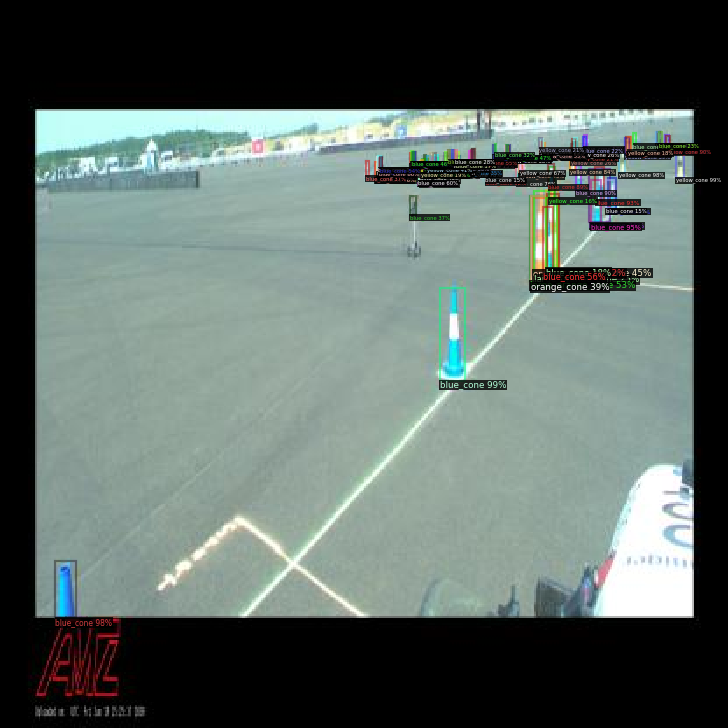

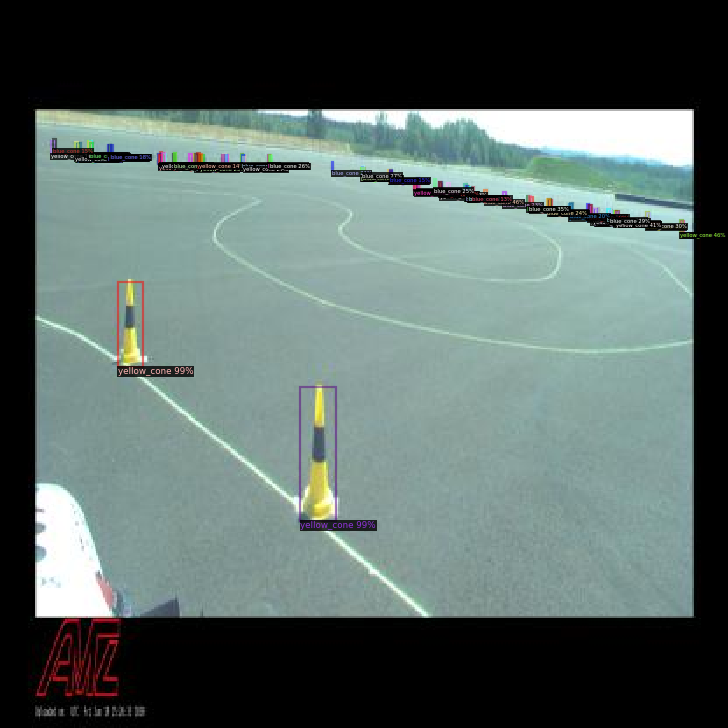

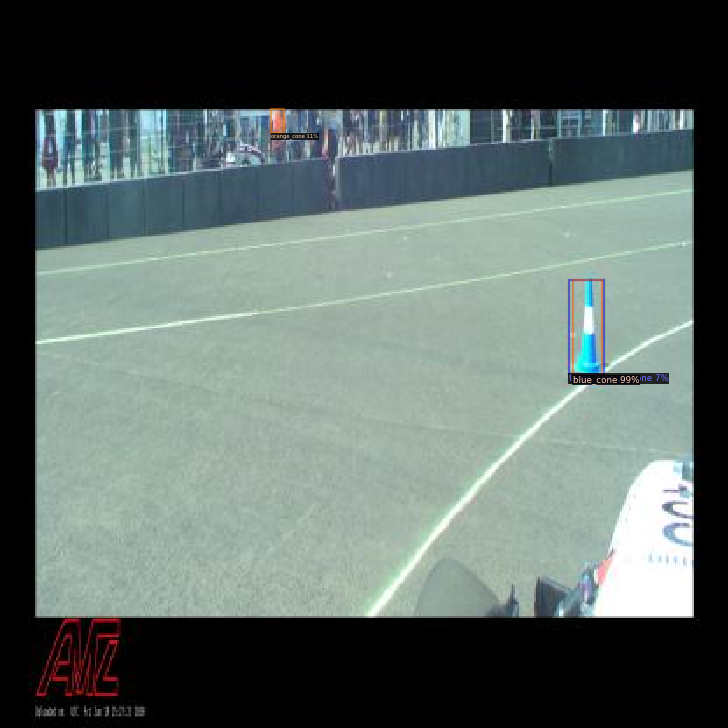

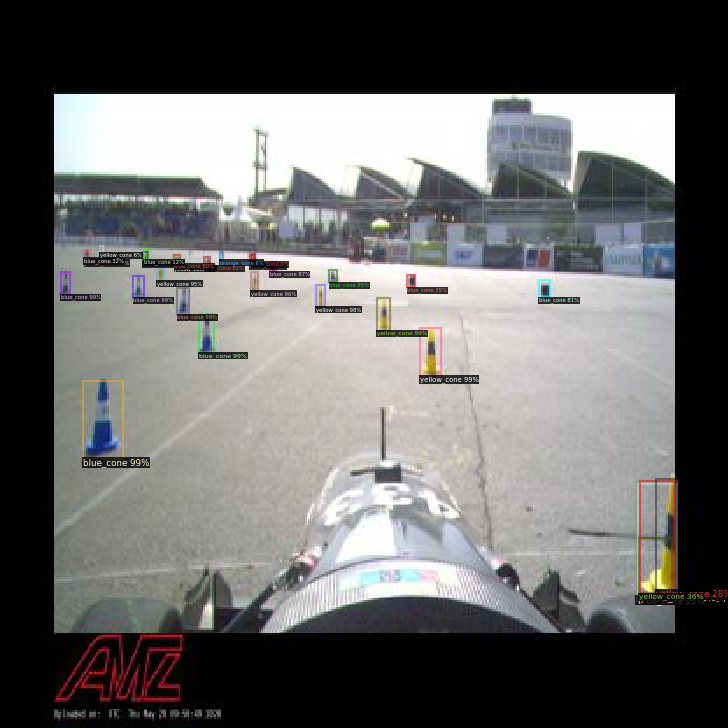

In [ ]:
import os, json, cv2, random
from google.colab.patches import cv2_imshow
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
cfg_test = get_cfg()
cfg_test.ONECYCLE = CfgNode({"LIMIT": 0.01, "MAX_MOMENTUM": 0.95, "MIN_MOMENTUM": 0.85, "THREE_PHASE": False})
cfg_test.merge_from_file(outdir + "/faster_R_50.yml")
cfg_test.MODEL.WEIGHTS = outdir + "/model_final.pth"
dataset_dicts = DatasetCatalog.get('cone_test')
num_samples = 4 # número de amostra para visualizar
with torch.no_grad():
  predictor = DefaultPredictor(cfg_test)
  model = predictor.model
  for det in random.sample(dataset_dicts, num_samples):
    img = cv2.imread(det["file_name"])
    outputs = predictor(img)
    v = Visualizer(img[:, :, ::-1], metadata=MetadataCatalog.get('cone_test'), scale=1.75)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])



#10 Visualização dos dados de treino(plot) e TensorBoard(opcional)

In [ ]:
import os
import json
metric_file = outdir+"/metrics.json"
metrics = []
with open(metric_file, 'r') as infile:
  for line in infile.readlines():
    metrics.append(json.loads(line))

APmetrics = metrics[-1] if "bbox/AP" in metrics[-1].keys() else None
if APmetrics is not None:
  metrics.pop(-1)
  APmetrics.pop('iteration', None) # não precisamos de iteration nos AP finais

mt = dict()
for k in metrics[0].keys():
  _temp = [metrics[i][k] for i in range(len(metrics))]
  mt.update({k: _temp})

In [ ]:
print("Keys válidas:", mt.keys())

Keys válidas: dict_keys(['data_time', 'eta_seconds', 'fast_rcnn/cls_accuracy', 'fast_rcnn/false_negative', 'fast_rcnn/fg_cls_accuracy', 'iteration', 'loss_box_reg', 'loss_cls', 'loss_rpn_cls', 'loss_rpn_loc', 'lr', 'roi_head/num_bg_samples', 'roi_head/num_fg_samples', 'rpn/num_neg_anchors', 'rpn/num_pos_anchors', 'time', 'total_loss', 'validation_loss_box_reg', 'validation_loss_cls', 'validation_loss_rpn_cls', 'validation_loss_rpn_loc', 'validation_total_loss'])


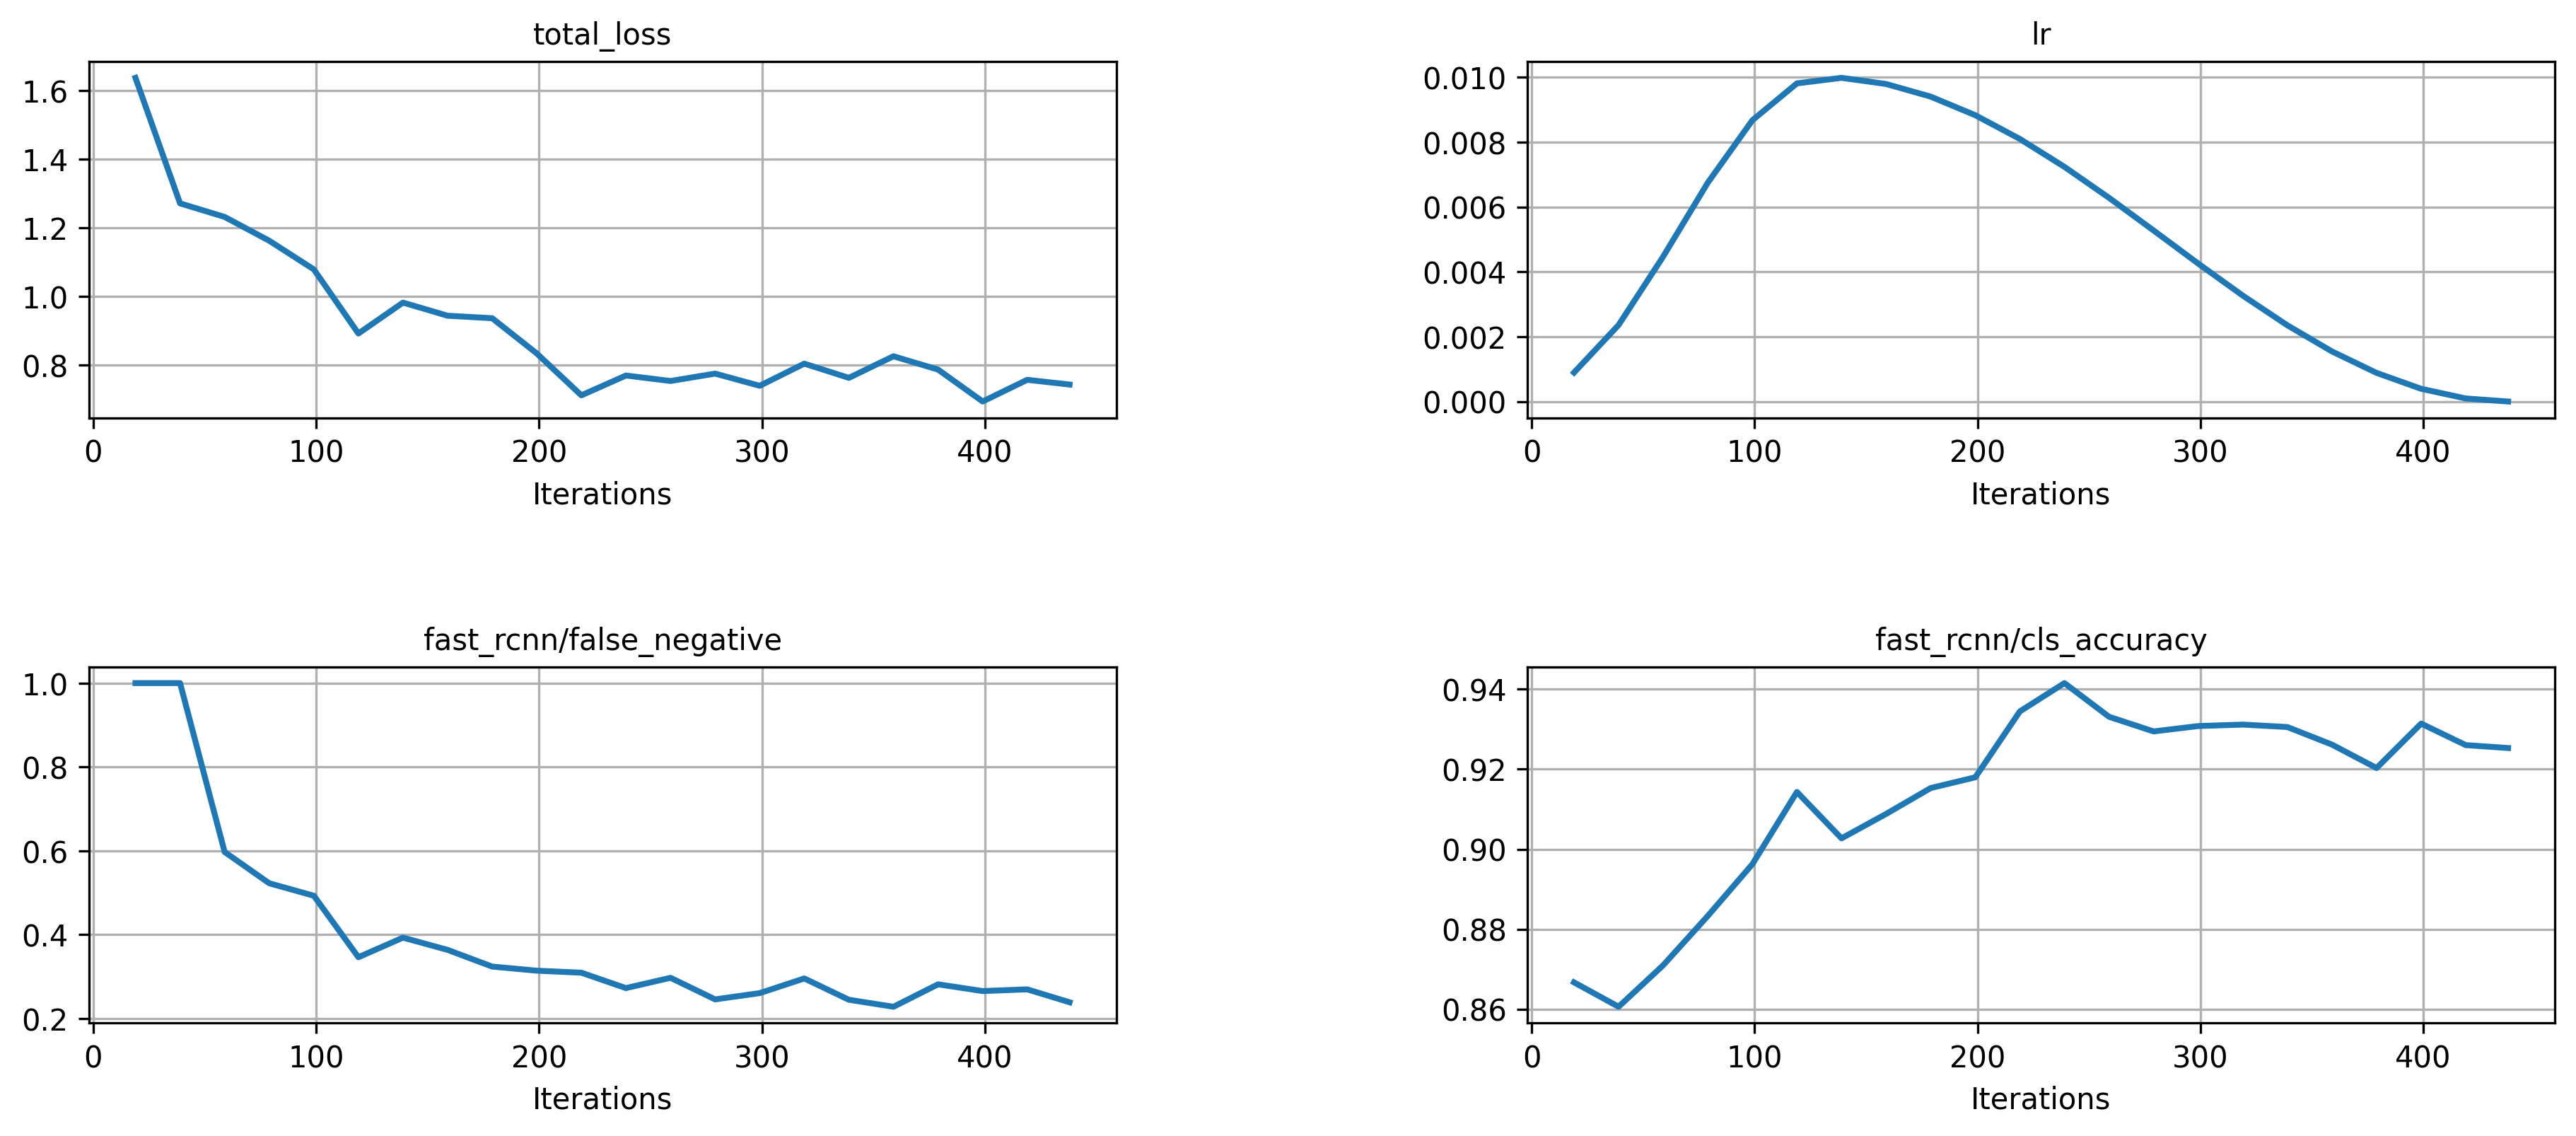

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
keys = ["total_loss", "lr", "fast_rcnn/false_negative", "fast_rcnn/cls_accuracy"] # adicionar keys válidas para mais plots.

fig = plt.figure(figsize=(15,6), dpi=300)
fig.subplots_adjust(hspace=0.7, wspace=0.4)
row_index = 2
line_index = (len(keys)//row_index)+1 if len(keys)%row_index != 0 else len(keys)//row_index
plotcount = 1
for k in keys:
  _ax = fig.add_subplot(line_index, row_index, plotcount)
  _ax.set_yscale('linear')
  _ax.plot(mt["iteration"], mt[k], linewidth=2.0)
  _ax.set_xlabel('Iterations', fontsize=10)
  _ax.set_title(k, fontsize=10)
  plt.grid()
  plotcount +=1
plt.show()

In [ ]:
#-- Visualizar inferência AP como tabela --
from IPython.display import display
import pandas as pd
if APmetrics is not None:
  df = pd.DataFrame.from_dict(APmetrics, orient='index') # key como linhas
  #df = pd.DataFrame(APmetrics, index=[0,]) # key como colunas
  display(df)

,0
bbox/AP,24.176695
bbox/AP-Cones,NaN
bbox/AP-blue_cone,33.992951
bbox/AP-large_orange_cone,27.784366
bbox/AP-orange_cone,25.078032
bbox/AP-unknown_cone,0.683135
bbox/AP-yellow_cone,33.344991
bbox/AP50,47.809784
bbox/AP75,22.028456
bbox/APl,77.623762


In [ ]:
%%script false --no-raise-error
#comentar a linha acima com "#" para executar a visualização com tensorboard no diretório de treino.
%load_ext tensorboard
%tensorboard --logdir "$outdir"

#11 Bloco para resumir um treino parado anteriormente [RESUMIR = True]




In [ ]:
from glob import glob
import time
import datetime
import pytz
if RESUMIR:
  pasta_para_resumir = PASTA_RESUMO
  if pasta_para_resumir == "":
    all_runs = glob(runs_path+"*/")
    lrt = len(runs_path)
    last_date = None
    last_run = None
    last_time = None
    for _run in all_runs:
      _date, _time = _run[lrt:-1].split('2022')
      run_date = time.strptime(_date + '2022', "%d-%m-%Y")
      run_hour, run_min, run_sec = _time.strip('_').split('_')
      run_time = run_hour*60 + run_min*60 + run_sec
      if last_date is None:
        last_date = run_date
        last_run = _run
        last_time = run_time
      elif run_date > last_date:
        lastaadptação_date = run_date
        last_run = _run
        last_time = run_time
      elif run_date == last_date:
        if run_time > last_time:
          last_date = run_date
          last_run = _run
          last_time = run_time
      else:
        pass
    pasta_para_resumir = last_run
  else:
    pasta_para_resumir = runs_path + PASTA_RESUMO + "/"

  print("Resumindo do diretorio:", pasta_para_resumir)
  models = glob(pasta_para_resumir+"*.pth")
  selected_model = None
  aux = 0
  for m in models:
    numbers = ''.join([x for x in m if x.isdigit()])
    if int(numbers) > aux:
      selected_model = m
      aux = int(numbers)
  print("Resumindo do modelo:", selected_model)
  time_now = datetime.datetime.now(pytz.timezone("America/Sao_Paulo"))
  #--msg logger--#
  _msg = "Iniciando configurações de resumo: OK"
  import IPython
  js_code = "const senderChannel = new BroadcastChannel('logger'); senderChannel.postMessage('{msg}');".format(msg=_msg)
  display(IPython.display.Javascript(js_code))
  #--msg logger (END) --#

In [ ]:
import detectron2
from detectron2.utils.logger import setup_logger
import matplotlib.pyplot as plt
import datetime
import pytz
import numpy as np
import cv2
import os
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.engine import DefaultTrainer
from detectron2.data.datasets import register_coco_instances
from detectron2 import model_zoo

if RESUMIR:
  #--msg logger--#
  time_now = datetime.datetime.now(pytz.timezone("America/Sao_Paulo"))
  _msg = "Iniciando resumo de treino: OK (resumo iniciado em {dia}/{mes}/{ano} as {hora}:{minuto}:{segundo})".format(dia=time_now.day, mes=time_now.month, ano=time_now.year, hora=time_now.hour, minuto=time_now.minute, segundo=time_now.second)
  import IPython
  js_code = "const senderChannel = new BroadcastChannel('logger'); senderChannel.postMessage('{msg}');".format(msg=_msg)
  display(IPython.display.Javascript(js_code))
  #--msg logger (END) --#

  setup_logger()

  runs_path = pasta_para_resumir # definindo run path de resumo
  cfg = get_cfg()
  cfg.ONECYCLE = CfgNode({"LIMIT": 0.01, "MAX_MOMENTUM": 0.95, "MIN_MOMENTUM": 0.85, "THREE_PHASE": False})
  cfg.merge_from_file(runs_path+"faster_R_50.yml")
  cfg.MODEL.WEIGHTS = selected_model
  register_coco_instances("cone_train", {}, "/content/dataset/train/_annotations.coco.json", "/content/dataset/train")
  register_coco_instances("cone_val", {}, "/content/dataset/valid/_annotations.coco.json", "/content/dataset/valid")
  print("Executando: " + str(cfg.SOLVER.MAX_ITER) + " iterations.")
  trainer = DermaTrainer(cfg)
  if VAL_TRAIN_LOSS:
    trainer.register_hooks([ValidationLoss(cfg)])
    pw_hook = [hook for hook in trainer._hooks if isinstance(hook, PeriodicWriter)]
    all_hooks = [hook for hook in trainer._hooks if not isinstance(hook, PeriodicWriter)]
    trainer._hooks = all_hooks + pw_hook
  if PLOT_LOSS:
    js_hook = LossLoggerJS()
    trainer.register_hooks([js_hook])
  if WANDB_LOGGER or NPT_LOGGER:
    exlogger_hook = ExternalLogger(npt=NPT_LOGGER, wndb=WANDB_LOGGER, resume=True)
    trainer.register_hooks([exlogger_hook])
  trainer.resume_or_load(resume=True) # True para resumir do checkpoint encontrado ou do melhor peso encontrado.
  trainer.train()
  time_now = datetime.datetime.now(pytz.timezone("America/Sao_Paulo"))

  #--msg logger--#
  _msg = "Resumo de treino finalizado em {dia}/{mes}/{ano} as {hora}:{minuto}:{segundo})".format(dia=time_now.day, mes=time_now.month, ano=time_now.year, hora=time_now.hour, minuto=time_now.minute, segundo=time_now.second)
  import IPython
  js_code = "const senderChannel = new BroadcastChannel('logger'); senderChannel.postMessage('{msg}');".format(msg=_msg)
  display(IPython.display.Javascript(js_code))
  #--msg logger (END) --#

<img src="http://lapix.ufsc.br/wp-content/uploads/2022/10/rodape-lapix.png">

